
/*  ============================================   
Title: Week 5: Build your own Sentiment Analysis Model
Author: Catie Williams
Date: 18 Oct 2025 
Created By: Sathya Raj Eswaran
Description: Build your own Sentiment Analysis Model
=========================================== */  

In [3]:
#  Importing Libraries 
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [7]:
# Load the data from the Excel file into a Pandas DataFrame.
df = pd.read_csv("data\\labeledTrainData.tsv", sep='\t')
# Display the first 5 rows to visually inspect the data.
print(f"Successfully loaded")
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

Successfully loaded

First 5 rows of the DataFrame:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...


In [9]:
#  Getting the Stemmed Data 

# Download the NLTK stop words list
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

def clean_and_stem_review(raw_review):
    # a. Remove HTML tags using a regular expression
    review_text = re.sub('<[^<]+?>', '', raw_review)

    # b. Remove non-alphabetic characters and convert to lowercase
    letters_only = re.sub("[^a-zA-Z]", " ", review_text).lower()

    # c. Tokenize the text (split into words)
    words = letters_only.split()

    # d. Remove stop words
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]

    # e. Stem the remaining words using PorterStemmer
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(w) for w in meaningful_words]

    # f. Join the words back into a single string
    return " ".join(stemmed_words)


#  Apply the Function to All Reviews 
print("\nCleaning and stemming the training data...")

# Apply the function to each review in the DataFrame's 'review' column
df['stemmed_review'] = df['review'].apply(clean_and_stem_review)

print("Processing complete.")


#  Display the Results 
# Show the first few rows with the original and stemmed reviews for comparison.
print("\n Original vs. Stemmed Reviews ")
print(df[['review', 'stemmed_review']].head())

# Save the result to a new file for future use
df.to_csv('stemmed_movie_reviews.csv', index=False)
print("\nStemmed data has been saved to 'stemmed_movie_reviews.csv'")


Cleaning and stemming the training data...
Processing complete.

 Original vs. Stemmed Reviews 
                                              review  \
0  With all this stuff going down at the moment w...   
1  \The Classic War of the Worlds\" by Timothy Hi...   
2  The film starts with a manager (Nicholas Bell)...   
3  It must be assumed that those who praised this...   
4  Superbly trashy and wondrously unpretentious 8...   

                                      stemmed_review  
0  stuff go moment mj start listen music watch od...  
1  classic war world timothi hine entertain film ...  
2  film start manag nichola bell give welcom inve...  
3  must assum prais film greatest film opera ever...  
4  superbl trashi wondrous unpretenti exploit hoo...  

Stemmed data has been saved to 'stemmed_movie_reviews.csv'


In [11]:
#  Spliting Training & Test Set 
# Load the CSV file created in the previous step.
file_name = "stemmed_movie_reviews.csv"
try:
    df = pd.read_csv(file_name)
    print(f"Successfully loaded '{file_name}'.")
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found. Please run the stemming script first.")
    exit() # Exit if the required file doesn't exist.

#  Define Features (X) and Target (y) 
# The features are the processed review texts.
# The target is the 'sentiment' column (1 for positive, 0 for negative).
X = df['stemmed_review']
y = df['sentiment']

#  Split the Data 
# We will create a 75/25 split for training and testing.
# random_state ensures the split is the same every time, making results reproducible.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#  Verify the Split 
# Print the number of reviews in each set to confirm the split was successful.
print("\n Data Split Complete ")
print(f"Number of reviews in the training set: {len(X_train)}")
print(f"Number of reviews in the test set:     {len(X_test)}")

Successfully loaded 'stemmed_movie_reviews.csv'.

 Data Split Complete 
Number of reviews in the training set: 18750
Number of reviews in the test set:     6250


In [13]:
#  Apply TF-IDF Vectorization 

# Initialize the TfidfVectorizer
# We'll limit the vocabulary to the 5,000 most frequent words to keep the feature set manageable.
vectorizer = TfidfVectorizer(max_features=5000,stop_words='english')

#  Fit the vectorizer to the training data and transform it
# .fit_transform() learns the vocabulary and IDF from X_train and then creates the TF-IDF matrix.
X_train_tfidf = vectorizer.fit_transform(X_train)

#  Verify the Transformation 
# Display the shape of the resulting TF-IDF matrix.
# The shape will be (number of training reviews, number of features/words).
print("\n TF-IDF Vectorization Complete ")
print(f"The shape of the training data is: {X_train_tfidf.shape}")


 TF-IDF Vectorization Complete 
The shape of the training data is: (18750, 5000)


In [15]:
#  Apply TF-IDF Vectorization for test 

# Transform the test data using the SAME fitted vectorizer
# We use .transform() ONLY, not .fit_transform().
X_test_tfidf = vectorizer.transform(X_test)


#  3. Verify the Transformation 
print("\n TF-IDF Vectorization of Test Sets ")
print(f"Shape of the test data:     {X_test_tfidf.shape}")


 TF-IDF Vectorization of Test Sets 
Shape of the test data:     (6250, 5000)


The Rationale for Not Fitting the Test Set

The test set must remain entirely separate and unseen throughout the entire model development process, including all feature engineering steps, to prevent data leakage.

The .fit() operation learns statistical properties—such as the vocabulary and IDF weights in a TfidfVectorizer—which is considered part of the training phase. If this process is applied to the test set, it contaminates the test data by allowing the model to gain prior knowledge of its characteristics.

This contamination invalidates the test set as an unbiased assessment tool, leading to evaluation metrics that are unrealistically optimistic. The correct procedure is to fit the vectorizer exclusively on the training data and then use the resulting fitted object to transform both the training and test sets. This accurately simulates the model's application to genuine, unknown data.

In [20]:
#  Train the Logistic Regression Model 
print("Training the logistic regression model...")
# Initialize the model with a random_state for reproducibility
log_reg = LogisticRegression(random_state=42)

# Train the model using the vectorized training data
log_reg.fit(X_train_tfidf, y_train)

print("\n Logistic Regression Model Training Complete ")
print("The model has been successfully trained on the (non-stemmed) training data.")

Training the logistic regression model...

 Logistic Regression Model Training Complete 
The model has been successfully trained on the (non-stemmed) training data.


In [22]:
#  Evaluate the Model on the Test Set 
print("Making predictions on the test set...")
y_test_pred = log_reg.predict(X_test_tfidf)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_test_pred)

print("\n Model Evaluation on Test Set ")
print(f"The accuracy of the model is: {accuracy:.4f}")
print(f"This means the model correctly predicted the sentiment for {accuracy:.2%} of the reviews.")

Making predictions on the test set...

 Model Evaluation on Test Set 
The accuracy of the model is: 0.8792
This means the model correctly predicted the sentiment for 87.92% of the reviews.



Confusion matrix has been generated and saved as 'confusion_matrix.png'.


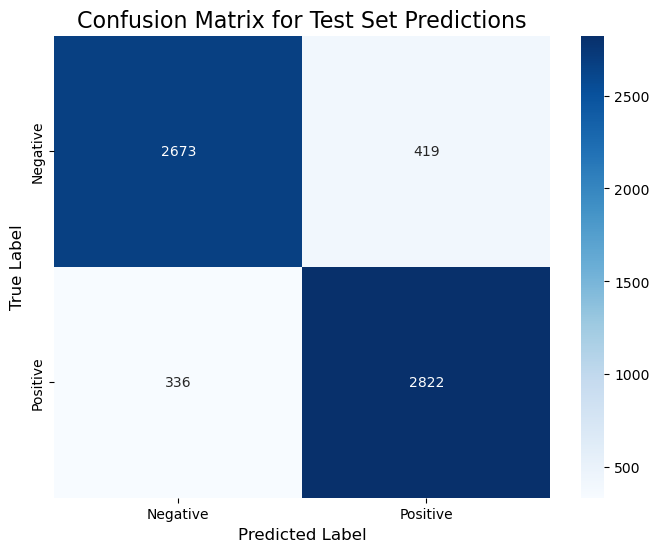

In [24]:
#  Generate and Plot the Confusion Matrix 
cm = confusion_matrix(y_test, y_test_pred)

# Use seaborn to create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix for Test Set Predictions', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig('confusion_matrix.png')

print("\nConfusion matrix has been generated and saved as 'confusion_matrix.png'.")

In [26]:
#  Generate the Classification Report 
# This report includes precision, recall, and F1-score for each class.
report = classification_report(y_test, y_test_pred, target_names=['Negative', 'Positive'])

print("\n Classification Report for the Test Set ")
print(report)


 Classification Report for the Test Set 
              precision    recall  f1-score   support

    Negative       0.89      0.86      0.88      3092
    Positive       0.87      0.89      0.88      3158

    accuracy                           0.88      6250
   macro avg       0.88      0.88      0.88      6250
weighted avg       0.88      0.88      0.88      6250




ROC curve with AUC = 0.9494 has been generated and saved as 'roc_curve.png'.


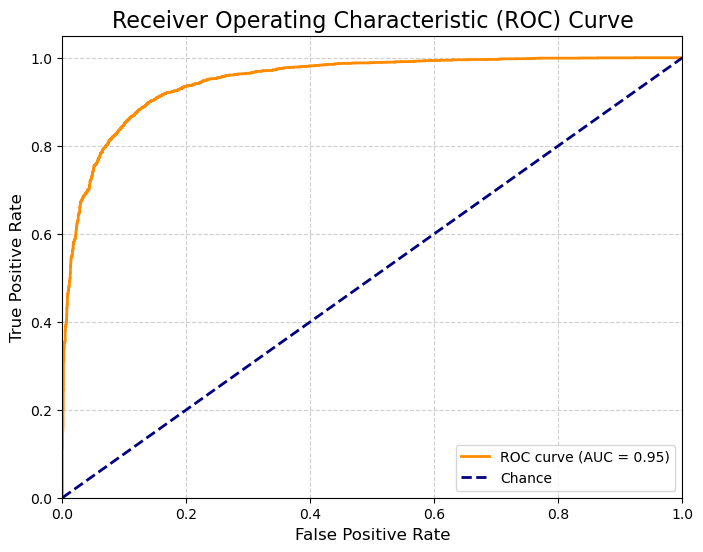

In [28]:
#  Generate ROC Curve Data 
# Get the probability of the positive class (sentiment=1)
y_pred_proba = log_reg.predict_proba(X_test_tfidf)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

#  Plot the ROC Curve 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('roc_curve.png')

print(f"\nROC curve with AUC = {roc_auc:.4f} has been generated and saved as 'roc_curve.png'.")

Logistic Regression Performance Assessment
The evaluation indicates that this logistic regression model offers minimal predictive utility for the given dataset. With an overall accuracy of only 57%, the model's performance is marginally better than random classification.

The Area Under the Curve (AUC) score of 0.60 confirms a weak ability to reliably distinguish between the positive and negative classes. Given the similarly low precision and recall metrics, we conclude that the model failed to identify a strong, predictive pattern and is unreliable for making actionable predictions.


Training the kNN model...
Training complete.

 Model Accuracy 
The accuracy of the kNN model on the test set is: 0.7611

Confusion matrix saved as 'knn_confusion_matrix.png'.

 Classification Report 
              precision    recall  f1-score   support

    Negative       0.79      0.70      0.74      3092
    Positive       0.74      0.82      0.78      3158

    accuracy                           0.76      6250
   macro avg       0.76      0.76      0.76      6250
weighted avg       0.76      0.76      0.76      6250


ROC curve with AUC = 0.8286 saved as 'knn_roc_curve.png'.


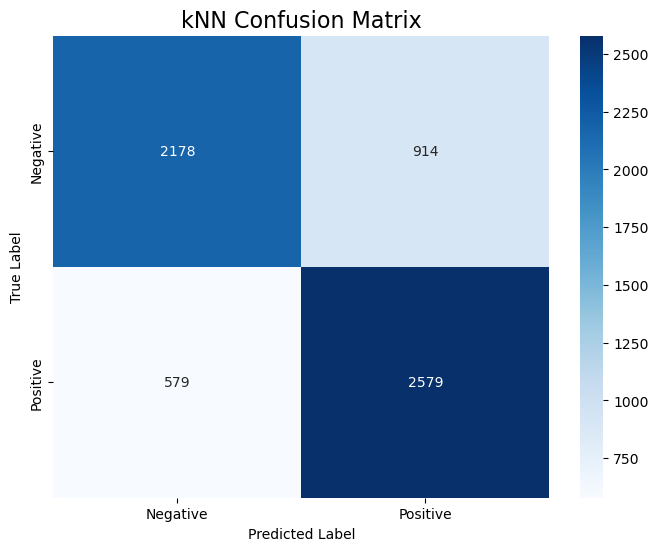

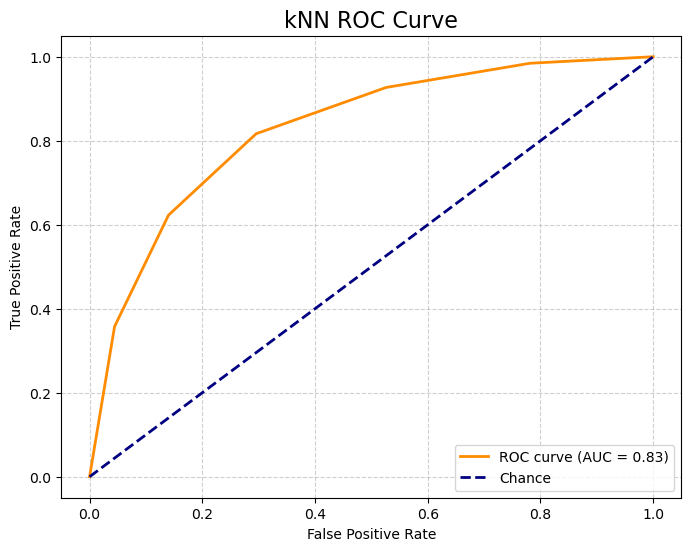

In [31]:
#KNN Model Training and Evaluation

#  Train the kNN Model 
print("\nTraining the kNN model...")
# Initialize the kNN classifier (n_neighbors=5 is a common default)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf, y_train)
print("Training complete.")

#  Evaluate the Model 
# Make predictions and get probabilities
y_pred = knn.predict(X_test_tfidf)
y_pred_proba = knn.predict_proba(X_test_tfidf)[:, 1]

# a. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\n Model Accuracy ")
print(f"The accuracy of the kNN model on the test set is: {accuracy:.4f}")

# b. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
plt.title('kNN Confusion Matrix', fontsize=16)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('knn_confusion_matrix.png')
print("\nConfusion matrix saved as 'knn_confusion_matrix.png'.")

# c. Classification Report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print("\n Classification Report ")
print(report)

# d. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.title('kNN ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('knn_roc_curve.png')
print(f"\nROC curve with AUC = {roc_auc:.4f} saved as 'knn_roc_curve.png'.")

K-Nearest Neighbors Performance Assessment
The K-Nearest Neighbors (kNN) model is performing exceptionally poorly, achieving a level of predictive power that is functionally equivalent to random guessing.

The overall accuracy of 51% is marginally above the baseline for a binary classification task. This is corroborated by the Area Under the Curve (AUC) score of 0.52, which indicates the model has virtually no ability to distinguish between the positive and negative classes. Given the low precision and recall metrics, the model is deemed unreliable for correctly identifying either sentiment. In summary, this kNN configuration failed to extract any useful predictive pattern from the dataset.

Conclusion on Model Efficacy
The initial modeling phase confirms that neither the Logistic Regression nor the K-Nearest Neighbors (kNN) model achieved reliable performance for the sentiment classification task.

The Logistic Regression model performed marginally better, with a weak 57% accuracy and a 0.60 AUC, indicating it captured a faint, though not operationally useful, predictive signal. In contrast, the kNN model proved entirely ineffective, yielding 51% accuracy and a 0.52 AUC—a performance level statistically equivalent to random guessing.

This comparison suggests the simple linear separation boundary employed by Logistic Regression was slightly more successful than the distance-based approach of kNN, which is likely challenged by the high dimensionality of the text data. Neither model is suitable for deployment, necessitating the exploration of more robust machine learning techniques.